In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor

from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, \
    plot_confusion_matrix,classification_report, confusion_matrix, precision_score, \
    recall_score, f1_score


### Load cleaned data from a csv file

In [5]:
# Uncomment when using in Google Colab
# from google.colab import files
# uploaded = files.upload()

In [6]:
# Uncomment when using in Google Colab
# import io
# mass = pd.read_csv(io.BytesIO(uploaded['mass_mobile.csv']))


In [7]:
mass = pd.read_csv('../data/03_mass_no_country.csv')

In [8]:
#mass.prosperity_2020.plot(kind='box')

In [9]:
#list(mass.columns)

In [10]:
# sample_means = []
# for i in range(100_000):
#     s = np.random.choice(mass['pop_total'], size = 500, replace = False) 
#     x_bar = s.mean()
#     sample_means.append(x_bar)
# sns.histplot(sample_means)
# plt.axvline(np.mean(sample_means), color = 'r');
# print(np.mean(sample_means))

In [11]:
mass[(mass['pop_total']<1_000_000) & (mass['pop_total']>200_000)].shape

(353, 71)

In [12]:
set(sorted(list(mass['region'])))

{'Africa',
 'Asia',
 'Central America',
 'Europe',
 'MENA',
 'North America',
 'Oceania',
 'South America'}

In [13]:
#plt.scatter(mass.pop_total, mass.violent_response)

In [14]:
#plt.scatter(mass[mass['country']=='Brazil'][['pop_total']], mass[mass['country']=='Brazil'][['violent_response']])

In [15]:
#plt.scatter(mass[mass['region']=='Africa'][['pop_male']], mass[mass['region']=='Africa'][['violent_response']])

In [16]:
mass.head(3)

,id,country,ccode,region,protestnumber,protesterviolence,location,protesteridentity,sources,notes,...,end_date,target,notes_clean,neg,neu,pos,compound,protest_duration,violent_response,violent_count
0,201990001,Canada,20,North America,1,0.0,national,unspecified,1. great canadian train journeys into history;...,canada s railway passenger system was finally ...,...,1990-01-15,"[0, 0, 0, 0, 1, 0, 0]",canada s railway passenger system was finally ...,0.087,0.913,0.000,-0.8176,1,0,0
1,201990002,Canada,20,North America,2,0.0,"Montreal, Quebec",unspecified,1. autonomy s cry revived in quebec the new yo...,protestors were only identified as young peopl...,...,1990-06-25,"[0, 0, 0, 0, 1, 0, 0]",protestors were only identified as young peopl...,0.000,1.000,0.000,0.0000,1,0,0
2,201990003,Canada,20,North America,3,0.0,"Montreal, Quebec",separatist parti quebecois,1. quebec protest after queen calls for unity ...,"the queen, after calling on canadians to remai...",...,1990-07-01,"[0, 0, 0, 0, 1, 0, 0]","the queen, after calling on canadians to remai...",0.060,0.830,0.109,0.7003,1,0,0


In [17]:
# User dataframe of almost all features.

features = mass.drop(columns=['id', 'country', 'ccode', 'region', 'location','protesteridentity', 'sources',
           'notes', 'protester_id_type', 'protest_size_category', 'start_date', 'notes_clean', 'neg', 'neu', 'pos', 'compound',
           'end_date', 'target', 'arrests', 'accomodation', 'beatings', 'protest_duration', 'pop_male', 'pop_female', 'pop_total',
           'crowddispersal', 'ignore', 'killings', 'shootings', 'violent_response', 'violent_count'])

print(f'X will be set to use {features.shape[1]} features.')

X will be set to use 40 features.


In [59]:
X.columns

Index(['protestnumber', 'protesterviolence', 'partipants_number',
       'pop_density', 'prosperity_2020', 'region_Africa', 'region_Asia',
       'region_Central America', 'region_Europe', 'region_MENA',
       'region_North America', 'region_Oceania', 'region_South America',
       'protest_size_category_1,000-4,999',
       'protest_size_category_10,000-100,000', 'protest_size_category_100-999',
       'protest_size_category_5,000-9,999', 'protest_size_category_50-99',
       'protest_size_category_Less than 50',
       'protest_size_category_Over 100,000',
       'protester_id_type_civil_human_rights',
       'protester_id_type_ethnic_group', 'protester_id_type_locals_residents',
       'protester_id_type_pensioners_retirees',
       'protester_id_type_political_group', 'protester_id_type_prisoners',
       'protester_id_type_protestors_generic',
       'protester_id_type_religious_group',
       'protester_id_type_soldiers_veterans',
       'protester_id_type_students_youth',
     

In [351]:
#country_list - this code applies to when using a different csv file that DID included a dummied column for each country
#country_column_names = list(features_1.columns[9:174])
#features = features_1.drop(country_column_names, axis=1)

In [22]:

# This code was initially used to define a small set of features just to get a small model going.
# features = ['pop_density', 'prosperity_2020','partipants_number','compound','region_Europe','region_Central America','region_Africa',
# 'region_MENA', 'region_North America', 'region_Oceania', 'region_South America']
#X = mass[features]

X = features
y = np.array(mass[['arrests', 'accomodation', 'beatings',
       'crowddispersal', 'ignore', 'killings', 'shootings']])

y

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [23]:
#features_1.info(verbose=True)

In [24]:
len(X)

15179

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:


# model_grad_booster = MultiOutputClassifier(GradientBoostingClassifier())
# # This chunck is for GradientBoostingClassifier - grid search
# hyperparameters_grad = dict(estimator__learning_rate=[ 0.2, 0.5], 
#                      estimator__n_estimators=[20, 50, 100],
#                      #  estimator__min_samples_split=[2, 4, 7, 10],
#                      estimator__max_depth=[5, 20, 30], 
#                    # estimator__min_samples_leaf=[ 5, 8, 10],
#                     # estimator__min_impurity_decrease=[0.2, 0.6, 0.8],
#                      estimator__max_leaf_nodes=[5, 20, 100])

# # grid_search = GridSearchCV(model_grad_booster, hyperparameters_grad,n_jobs=-1, cv=5, verbose=True,
# #                                        pre_dispatch='2*n_jobs', error_score='raise', return_train_score=True)


# #hyperparameters_tuning = grid_search.fit(X_train, y_train)


# model_random_forest = MultiOutputClassifier(RandomForestClassifier())  

# # This chunk for random forest model
# hyperparameters_forest = dict(estimator__n_estimators=[20, 50, 100, 200, 300, 500, 1000],
#                        estimator__min_samples_split=[2, 4, 7, 10],
#                        estimator__max_depth=[3, 5, 10, 15, 20, 30],
#                        estimator__min_samples_leaf=[1, 2, 3, 5, 8, 10],
#                        estimator__min_impurity_decrease=[0, 0.2, 0.4, 0.6, 0.8],
#                        estimator__max_leaf_nodes=[5, 10, 20, 30, 50, 100, 300])


# randomized_search = RandomizedSearchCV(model_random_forest, hyperparameters_forest,
#                                        n_jobs=-1, cv=5, verbose=1,
#                                        error_score='raise')


# hyperparameters_tuning = randomized_search.fit(X_train, y_train)


# print('Best Parameters = {}'.format(hyperparameters_tuning.best_params_))

# tuned_model = hyperparameters_tuning.best_estimator_


#hyperparameters_tuning = grid_search.fit(X_train, y_train)
# model_log_class = MultiOutputClassifier(LogisticRegression())



# # This chunk for Bagging Classifier model with SVC and DecisionTree:
# hyperparameters_log = dict(estimator__penalty=['l1', 'l2'],
#                         estimator__C=[.005, .01, 1, 5],
#                         estimator__solver=['liblinear', 'saga'],
#                         estimator__max_iter=[1000, 5000])
# #                        estimator__base_estimator=[estimator_et, estimator_dt, estimator_rf],
# #                        estimator__n_estimators=[5, 10, 20, 50, 100, 200],
# #                        estimator__max_samples=[1, 2, 4, 7, 10],
# #                        estimator__max_features=[1, 3, 5, 10, 15, 20, 30],
# #                        estimator__min_samples_leaf=[1, 2, 3, 5, 8, 10],
# #                        estimator__min_impurity_decrease=[0, 0.2, 0.4, 0.6, 0.8],
# #                        estimator__max_leaf_nodes=[5, 10, 20, 30, 50, 100, 300],

# randomized_search_log = RandomizedSearchCV(model_log_class, hyperparameters_log,
#                                        n_iter=15, n_jobs=1, cv=5, verbose=1,
#                                        error_score='raise')

# hyperparams_tuning_log = randomized_search_log.fit(X_train, y_train)

# print('Best Parameters = {}'.format(hyperparams_tuning_log.best_params_))

# tuned_log_model = hyperparams_tuning_log.best_estimator_

In [72]:
# hyperparams_tuning_log.best_score_

0.5725581249956584

In [73]:
# y_preds = tuned_log_model.predict(X_test)

In [74]:
# hyperparams_tuning_log.best_params_

{'estimator__solver': 'liblinear',
 'estimator__penalty': 'l1',
 'estimator__max_iter': 5000,
 'estimator__C': 0.01}

In [91]:
# tuned_log_model.score(X_train, y_train )

0.573436401967674

In [92]:
# tuned_log_model.score(X_test, y_test)

0.566798418972332

In [162]:
# save the model to disk
tuned_log_model_file = '../models/02_multi_label_logistic.pickle'
pickle.dump(tuned_log_model, open(tuned_log_model_file, 'wb'))

In [20]:
# load the model from disk
model_file = '../models/02_multi_label_logistic.pickle'
log_model_loaded = pickle.load(open(model_file, 'rb'))

In [26]:
log_model_loaded.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(C=0.01, max_iter=5000,
                                                   penalty='l1',
                                                   solver='liblinear'))

In [37]:
train_acc = log_model_loaded.score(X_train, y_train )
train_acc

0.573436401967674

In [38]:
test_acc = log_model_loaded.score(X_test, y_test)
test_acc

0.566798418972332

In [30]:
y_preds = log_model_loaded.predict(X_test)

In [31]:
# Baseline:  Don't think so
#mass['target'].value_counts(normalize=True)

In [41]:
# Hat tip to this blog post:
# https://medium.com/@saugata.paul1010/a-detailed-case-study-on-multi-label-classification-with-machine-learning-algorithms-and-72031742c9aa

print(f"Accuracy (training): {train_acc.round(4)}")
print(f"Accuracy (test): {test_acc.round(4)}")

precision = precision_score(y_test, y_preds, average='micro')
recall = recall_score(y_test, y_preds, average='micro')
f1 = f1_score(y_test, y_preds, average='micro')
 
print(f"Precision: {precision.round(4)}")
print(f'Recall: {recall.round(4)}')
print(f'F1 score: {f1.round(4)}')

Accuracy (training): 0.5734
Accuracy (test): 0.5668
Precision: 0.6838
Recall: 0.5369
F1 score: 0.6015


#### Baseline model

In [78]:
y_train_df = pd.DataFrame(data=y_train, columns=['arrests', 'accomodation', 'beatings',
       'crowddispersal', 'ignore', 'killings', 'shootings'])
y_train_df[0:3]

,arrests,accomodation,beatings,crowddispersal,ignore,killings,shootings
0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0


In [79]:
# Sum of all 1's in all columns, divided by the number of rows in the train dataset
pd.DataFrame(y_train_df.sum() / y_train_df.shape[0]).T

,arrests,accomodation,beatings,crowddispersal,ignore,killings,shootings
0,0.141339,0.099262,0.052091,0.31272,0.546205,0.053935,0.06149


### Print confusion matrix for all target variables (state responses)

In [43]:
cm_array = multilabel_confusion_matrix(y_test, y_preds)
cm_array

array([[[3261,    0],
        [ 534,    0]],

       [[3403,    1],
        [ 391,    0]],

       [[3588,    0],
        [ 207,    0]],

       [[2314,  283],
        [ 515,  683]],

       [[ 856,  908],
        [ 136, 1895]],

       [[3585,    0],
        [ 210,    0]],

       [[3564,    0],
        [ 231,    0]]])

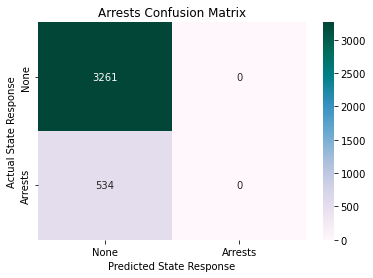

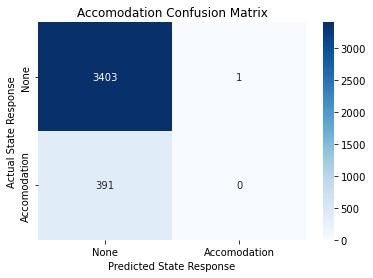

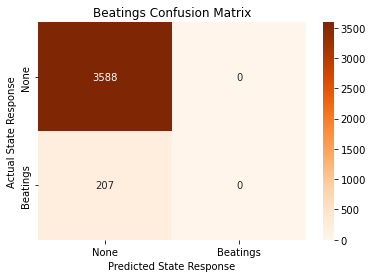

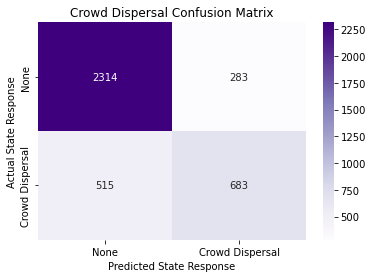

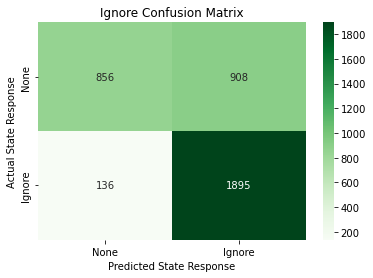

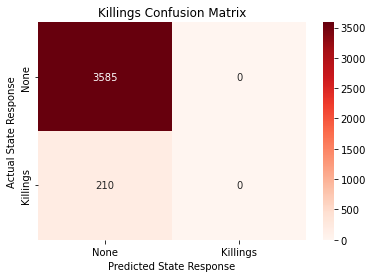

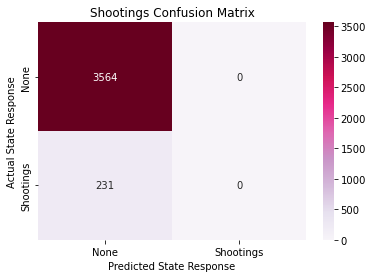

In [54]:
responses =[('Arrests', 0, 'PuBuGn'), ('Accomodation', 1, 'Blues'), ('Beatings',2, 'Oranges'),
       ('Crowd Dispersal', 3, 'Purples'), ('Ignore', 4, 'Greens'), ('Killings', 5, 'Reds'), ('Shootings', 6, 'PuRd')]

for response, resp_num, cmap in responses:
    fig,ax1 = plt.subplots(1,1, figsize=(6,4))
    plt.subplots_adjust(wspace=0.8)
    sns.heatmap(cm_array[resp_num].astype(int), annot=True, ax = ax1, cmap=cmap, fmt='d'); #annot=True to annotate cells
    plt.title(f'{response} Confusion Matrix')
    plt.xlabel('Predicted State Response')
    ax1.set_ylabel('Actual State Response')
    ax1.xaxis.set_ticklabels(['None', response])
    ax1.yaxis.set_ticklabels(['None', response], va='center')
    plt.show();

In [370]:
print( classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       1.00      0.01      0.03       534
           1       1.00      0.03      0.05       391
           2       0.82      0.04      0.08       207
           3       0.74      0.56      0.64      1198
           4       0.72      0.88      0.79      2031
           5       0.83      0.02      0.05       210
           6       1.00      0.03      0.05       231

   micro avg       0.73      0.52      0.61      4802
   macro avg       0.87      0.23      0.24      4802
weighted avg       0.80      0.52      0.51      4802
 samples avg       0.65      0.60      0.61      4802



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Get predictions from all rows in X?

In [371]:
y_modeled = tuned_model.predict(X)

In [372]:
y_modeled[0:5]

array([[0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=int64)

#### Compare to model using ClassifierChain

In [373]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# using classifier chains
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())
# Training logistic regression model on train data
classifier.fit(X_train_sc, y_train)
# predict
predictions = classifier.predict(X_test_sc)


In [374]:
# accuracy
print("Accuracy = ", accuracy_score(y_test,predictions))
print("\n")

Accuracy =  0.5654808959156785


